## An experiment to understand AIC

Based on McElreath, Rethinking Statistics, Chapter 6.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

We generate data from a gaussian with standard deviation 1 and means given by:

$$\mu_i = 0.15 x_{1,i} - 0.4 x_{2,i}, y \sim N(\mu, 1).$$

We use an interesting trick to generate this data, directly using the regression coefficients as correlations with the response variable.

In [2]:
def generate_data(N, k, rho=[0.15, -0.4]):
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.eye(n_dim)
    for i,r in enumerate(rho):
        Rho[0, i+1] = r
    index_lower = np.tril_indices(n_dim, -1)
    Rho[index_lower] = Rho.T[index_lower]
    mean = n_dim * [0.]
    Xtrain = np.random.multivariate_normal(mean, Rho, size=N)
    Xtest = np.random.multivariate_normal(mean, Rho, size=N)
    ytrain = Xtrain[:,0].copy()
    Xtrain[:,0]=1.
    ytest = Xtest[:,0].copy()
    Xtest[:,0]=1.
    return Xtrain[:,:k], ytrain, Xtest[:,:k], ytest

We want to generate data for 5 different cases, a one parameter (intercept) fit, a two parameter (intercept and $x_1$), three parameters (add a $x_2), and four and five parameters. Here is what the data looks like for 2 parameters:

In [3]:
generate_data(20,2)

(array([[ 1.        , -0.83978695],
        [ 1.        , -0.60882982],
        [ 1.        ,  1.02567296],
        [ 1.        ,  0.24801809],
        [ 1.        , -1.08181661],
        [ 1.        , -1.85677575],
        [ 1.        ,  1.82835523],
        [ 1.        ,  0.35622585],
        [ 1.        , -0.04159412],
        [ 1.        ,  0.58678675],
        [ 1.        , -0.24396323],
        [ 1.        , -0.07081137],
        [ 1.        ,  0.46510137],
        [ 1.        , -1.02993129],
        [ 1.        , -2.08756332],
        [ 1.        ,  0.60666556],
        [ 1.        ,  0.45913243],
        [ 1.        ,  0.60083017],
        [ 1.        , -1.05726496],
        [ 1.        , -0.52258973]]),
 array([-1.11513393, -0.50856507,  0.50782261, -0.09031626,  0.41992084,
        -0.82404287,  0.27567933,  0.3626567 ,  0.99109211,  1.14742966,
         0.53597334, -1.2959274 ,  2.12659247,  0.09595858,  0.05845798,
         0.47581813, -1.02115871,  0.83942264,  0.33097791,

And for four parameters

In [5]:
generate_data(20,4)

(array([[  1.00000000e+00,  -5.64117484e-01,  -1.30408291e+00,
          -4.06307198e-01],
        [  1.00000000e+00,   2.45856192e-01,  -1.13160363e+00,
           6.99099707e-01],
        [  1.00000000e+00,  -5.92401483e-01,  -5.51929080e-01,
           1.70288811e-01],
        [  1.00000000e+00,   1.40350006e+00,  -7.42482462e-01,
           6.90299071e-01],
        [  1.00000000e+00,  -1.14026512e+00,   2.27882734e-01,
          -2.80250494e-01],
        [  1.00000000e+00,  -1.79114172e-01,   1.71257237e+00,
           1.32182974e+00],
        [  1.00000000e+00,   8.39677171e-01,  -2.07787502e-01,
           1.20281542e+00],
        [  1.00000000e+00,  -9.38668901e-01,  -5.87192846e-01,
           9.91223102e-01],
        [  1.00000000e+00,  -4.11883974e-01,  -1.31283133e+00,
          -9.42131126e-01],
        [  1.00000000e+00,   5.27622295e-01,   2.98370087e-01,
          -3.13398528e-01],
        [  1.00000000e+00,   1.75945182e+00,  -9.55446150e-01,
          -5.65605486e-01],

In [8]:
from scipy.stats import norm
import statsmodels.api as sm

//anaconda/envs/py3l/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Analysis, n=20

Here is the main loop of our analysis. We take the 5 models we talked about. For each model we generate 10000 samples of the data, split into an equal sized (N=20 each) training and testing set. We fit the regression on the training set, and calculate the deviance on the training set. Notice how we have simply used the `logpdf` from `scipy.stats`. You can easily do this for other distributions.

We then use the fit to calculate the $\mu$ on the test set, and calculate the deviance there. We then find the average and the standard deviation across the 10000 simulations.

In [9]:
reps=10000
results_20 = {}
for k in range(1,6):
    trdevs=np.zeros(reps)
    tedevs=np.zeros(reps)
    for r in range(reps):
        Xtr, ytr, Xte, yte = generate_data(20, k)
        ols = sm.OLS(ytr, Xtr).fit()
        mutr = np.dot(Xtr, ols.params)
        devtr = -2*np.sum(norm.logpdf(ytr, mutr, 1))
        mute = np.dot(Xte, ols.params)
        #print(mutr.shape, mute.shape)
        devte = -2*np.sum(norm.logpdf(yte, mute, 1))
        #print(k, r, devtr, devte)
        trdevs[r] = devtr
        tedevs[r] = devte
    results_20[k] = (np.mean(trdevs), np.std(trdevs), np.mean(tedevs), np.std(tedevs))

In [10]:
import pandas as pd
df = pd.DataFrame(results_20).T
df = df.rename(columns = dict(zip(range(4), ['train', 'train_std', 'test', 'test_std'])))
df

,train,train_std,test,test_std
1,55.669331,6.185150,57.688110,6.825813
2,54.301259,5.930990,58.513912,7.284745
3,50.669082,4.778731,56.111054,6.668364
4,49.744479,4.585390,57.414846,7.505377
5,49.026424,4.431733,58.718321,8.279063


In [11]:
import seaborn.apionly as sns
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

We plot the traing and testing deviances

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


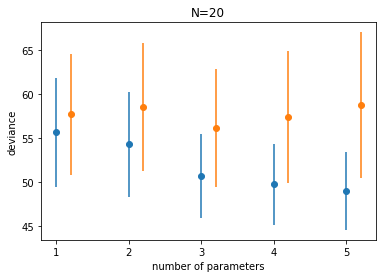

In [13]:
plt.plot(df.index, df.train, 'o', color = colors[0])
plt.errorbar(df.index, df.train, yerr=df.train_std, fmt=None, color=colors[0])
plt.plot(df.index+0.2, df.test, 'o', color = colors[1])
plt.errorbar(df.index+0.2, df.test, yerr=df.test_std, fmt=None, color=colors[1])
plt.xlabel("number of parameters")
plt.ylabel("deviance")
plt.title("N=20");

Let us see the difference between the mean testing and training deviances. This is the difference in *bias* between the two sets.

In [14]:
df.test - df.train

1    2.018779
2    4.212654
3    5.441971
4    7.670368
5    9.691897
dtype: float64

Voila, this seems to be roughly twice the number of parameters. In other words we might be able to get away without a test set if we "correct" the bias on the traing set by $2n_p$. This is the observation that motivates the AIC.

### Analysis N=100

In [ ]:
reps=10000
results_100 = {}
for k in range(1,6):
    trdevs=np.zeros(reps)
    tedevs=np.zeros(reps)
    for r in range(reps):
        Xtr, ytr, Xte, yte = generate_data(100, k)
        ols = sm.OLS(ytr, Xtr).fit()
        mutr = np.dot(Xtr, ols.params)
        devtr = -2*np.sum(norm.logpdf(ytr, mutr, 1))
        mute = np.dot(Xte, ols.params)
        devte = -2*np.sum(norm.logpdf(yte, mute, 1))
        #print(k, r, devtr, devte)
        trdevs[r] = devtr
        tedevs[r] = devte
    results_100[k] = (np.mean(trdevs), np.std(trdevs), np.mean(tedevs), np.std(tedevs))

In [ ]:
df100 = pd.DataFrame(results_100).T
df100 = df100.rename(columns = dict(zip(range(4), ['train', 'train_std', 'test', 'test_std'])))
df100

In [ ]:
plt.plot(df100.index, df100.train, 'o', color = colors[0])
plt.errorbar(df100.index, df100.train, yerr=df100.train_std, fmt=None, color=colors[0])
plt.plot(df100.index+0.2, df100.test, 'o', color = colors[1])
plt.errorbar(df100.index+0.2, df100.test, yerr=df100.test_std, fmt=None, color=colors[1])
plt.xlabel("number of parameters")
plt.ylabel("deviance")
plt.title("N=100");

In [234]:
df100.test - df100.train

1    1.900383
2    3.908291
3    5.193728
4    7.003606
5    8.649499
dtype: float64

We get pretty much the same result at N=100.